`Adapted from ng-video-lecture by Andrej Karpathy`

`Original source: https://github.com/karpathy/ng-video-lecture`

`Simplified and modified for clarity and educational use`

### Data & Tokenization:
A huge corpus of text from which the model will learn to talk, along with the knowledge inherent in the data. For example, if most of the times in the data, the text ‘What the’ is followed by ‘hell’, it would learn that pattern and will be able to produce it. 

Usually, long texts are considered for training data, like a whole novel, and we need to get rid of very short texts. We could also consider short texts but then a lot of complexity related to padding will arise, and short sequences won't add value to the learning.

In [3]:
# Loading data
paragraphs = [
    '''Politics may be used positively in the context of a "political solution" which is compromising and
    non-violent, or descriptively as "the art or science of government", but the word often also carries a
    negative connotation. The concept has been defined in various ways, and different approaches have
    fundamentally differing views on whether it should be used extensively or in a limited way, empirically
    or normatively, and on whether conflict or co-operation is more essential to it.''', 

    "Hello World!",
    
    '''Education is the transmission of knowledge and skills and the development of character traits.
    Formal education occurs within a structured institutional framework, such as public schools, following
    a curriculum. Non-formal education also follows a structured approach but occurs outside the formal
    schooling system, while informal education involves unstructured learning through daily experiences.
    Formal and non-formal education are categorized into levels, including early childhood education,
    primary education, secondary education, and tertiary education. Other classifications focus on teaching
    methods, such as teacher-centered and student-centered education, and on subjects, such as science education,
    language education, and physical education. Additionally, the term "education" can denote the mental states
    and qualities of educated individuals and the academic field studying educational phenomena.'''
]

# Clean up line breaks due to manually pasting the data
paragraphs = [p.replace('\n   ','') for p in paragraphs]
paragraphs

['Politics may be used positively in the context of a "political solution" which is compromising and non-violent, or descriptively as "the art or science of government", but the word often also carries a negative connotation. The concept has been defined in various ways, and different approaches have fundamentally differing views on whether it should be used extensively or in a limited way, empirically or normatively, and on whether conflict or co-operation is more essential to it.',
 'Hello World!',
 'Education is the transmission of knowledge and skills and the development of character traits. Formal education occurs within a structured institutional framework, such as public schools, following a curriculum. Non-formal education also follows a structured approach but occurs outside the formal schooling system, while informal education involves unstructured learning through daily experiences. Formal and non-formal education are categorized into levels, including early childhood educat

In practice, the whole dataset is not loaded in python but kept in a **streamed (joined)** text file. The joining is done with a special `end_of_document` token. So it becomes a very long sequene of tokens.

Then chunks from random positions are picked in batches and passed into training. It saves the memory to load entire dataset. We will implement similar thing with this small data but we will load the data for better explanation. 

*(note - there is a chance that a random chunk consists of both left and right sides of `end_of_document` token, which is not perfect, but when we have long documents like novels, these are negligible)*.

In [4]:
# Keeping only those documents which are long enough i.e. >10 words
paragraphs = [p for p in paragraphs if len(p.split())>10]

# Streamimg data with end_of_document token (for GPT2 this token is <|endoftext|>)
texts = '<|endoftext|>'.join(paragraphs)

# Tokenizing
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", progress_bar = False)
print('end of document token: ', tokenizer.encode('<|endoftext|>'))
tokens = tokenizer.encode(texts)
print("\ntokens: \n", tokens)

# Selecting random chunks of size 6 in a batch of 4
import numpy as np
np.random.seed(1)
B = 4
T = 6
x = list()
for _ in range(B):
    start_position = np.random.randint(0, len(tokens) - T)
    x.append(tokens[start_position : start_position + T])
print("\nA selected batch: \n", np.array(x))

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

end of document token:  [50256]

tokens: 
 [43921, 743, 307, 973, 19888, 287, 262, 4732, 286, 257, 366, 23149, 4610, 1, 543, 318, 35294, 290, 1729, 12, 24498, 11, 393, 12145, 2280, 355, 366, 1169, 1242, 393, 3783, 286, 1230, 1600, 475, 262, 1573, 1690, 635, 10732, 257, 4633, 369, 38983, 13, 383, 3721, 468, 587, 5447, 287, 2972, 2842, 11, 290, 1180, 10581, 423, 17640, 28742, 5009, 319, 1771, 340, 815, 307, 973, 20823, 393, 287, 257, 3614, 835, 11, 18097, 1146, 393, 2593, 9404, 11, 290, 319, 1771, 5358, 393, 763, 12, 27184, 318, 517, 6393, 284, 340, 13, 50256, 41183, 318, 262, 11478, 286, 3725, 290, 4678, 290, 262, 2478, 286, 2095, 12796, 13, 5178, 282, 3707, 8833, 1626, 257, 20793, 15855, 9355, 11, 884, 355, 1171, 4266, 11, 1708, 257, 20583, 13, 8504, 12, 687, 282, 3707, 635, 5679, 257, 20793, 3164, 475, 8833, 2354, 262, 8766, 36946, 1080, 11, 981, 22176, 3707, 9018, 555, 7249, 1522, 4673, 832, 4445, 6461, 13, 5178, 282, 290, 1729, 12, 687, 282, 3707, 389, 37661, 656, 2974, 11, 1390, 19

Since we excluded the short document, we are left with only 2 documets joined with end of document token 50256. Then we pick 4 sequences with random starting points from this long stream of tokens.

Here, we used pre-configured GPT2 tokenizer which has a vocabulary of >50K sub-words mapped to integers. For the further understanding of the model, we will consider a randomly generated input sequence with only 100 vocabulary items. So the token ids will span from 0 to 99. If we are able to finally generate tokens within 0-99, then we can be sure that the i/o is setup correctly. Let's get into it.

### Embedding - First Forward Pass

Suppose we have a batch of sequences selected as $X^{B \times T}$ 

In [5]:
import numpy as np
np.random.seed(1)

B = 4
T = 6
V = 100

# Suppose this is a batch of sequences randomly picked from the whole sequence
x = np.random.randint(0, V-1, (B, T))
x

array([[37, 12, 72,  9, 75,  5],
       [79, 64, 16,  1, 76, 71],
       [ 6, 25, 50, 20, 18, 84],
       [11, 28, 29, 14, 50, 68]])

### Token Embedding: 

Before putting it into Transformer, we shall pass it through an embedding lookup. This lookup helps to create a floating-point representation of integer indices.

Each of the integer 0-99 in the vocabulary are associated with a row in the embedding table. When we get token 0, the first row will be plucked, when we get token 4, the 5th row will be plucked, and so on.

$E^{V \times C}$ is the token embedding table,where 

$V$:vocabulary size 100

$C$:Embedding dimension 10 

The result of applying embedding is a $(B \times T \times C)$ matrix because we pluck the $C$ dimensional embedding row for each of the $T$ tokens in each of the $B$ sequences in a batch.

Result: Embedded ${X\_tok\_embed}^{B \times T \times C}$

The elements of E are trainable and hence will participate in back-propagation. We train these so that the floating-point representation becomes highly clustered i.e. similar words get similar embedding vector.

In [6]:
# Token Embedding (but not trainable because it's not a tensor with grad)
np.random.seed(2)
C = 10
E = np.random.rand(V, C)
print("E.shape: ", E.shape)

# Looking up the embedding
x_tok_embed = E[x]
print("x_tok_embed.shape: ", x_tok_embed.shape)

E.shape:  (100, 10)
x_tok_embed.shape:  (4, 6, 10)


### Positional Embedding: 

Although we keep maintaining the order of tokens in the sequence, when we input it into Transformer, it does not consider that order. A sequence is treated as a bag of words, only positional relations given by attention mask, but they dont say which one is first word, which one is second word and so on. 

That is why we need to explicitly put a representation of the order of those embedded elements. We simply initialize another embedding lookup table P having T x C elements.

$X\_pos$: Positions

$P^{T \times C}$ is the positional embedding table,where 

$T$:context length 6

$C$:Embedding dimension 10 

Result: Embedded $X\_pos\_embed^ {B \times T \times C}$

Same way, the elements of P are trainable when we initialize them as tensors rather than numpy arrays.

*Note: In the transformer paper, which relates to translation task, these are not taken as embeddings, rather a smooth sinusoidal function.*

In [7]:
# Positional Embedding (but not trainable because it's not a tensor with grad)
np.random.seed(3)
P = np.random.rand(T, C)
print("P.shape: ", P.shape)

# Creating matrix of same shape with position numbers, skipping the pads
col_indices = np.arange(x.shape[1])
x_pos = np.vstack([col_indices]*B)
print("\nX positions: \n", x_pos)

# Looking up the embedding
x_pos_embed = P[x_pos]
print("\nx_pos_embed.shape: ", x_pos_embed.shape)

P.shape:  (6, 10)

X positions: 
 [[0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]
 [0 1 2 3 4 5]]

x_pos_embed.shape:  (4, 6, 10)


### Final Embeddings:

We then add the token embeddings and positional embeddings and save it as $X\_embed^{B \times T \times C}$

In [8]:
x_embed = x_tok_embed + x_pos_embed

### Overall Model Architecture

This GPT model is designed to be trained with predictor $X[:,:-1]$ i.e. all except last token in the sequence, vs target as $X[:,:1:]$ i.e. all except first token in the sequence. So, each token is trained to predict its next token. This is why our time dimension reduces from $T$ to $(T-1)$

In a forward pass, we shall be passing the $X[:,:-1]$ i.e. all except last token, through multiple transformer decoder layers. This returns $B \times (T-1) \times C$ logits. We just assume this in part1 and learn this in part2.

Also, for simplicity of syntax, let's call $t = T - 1$.

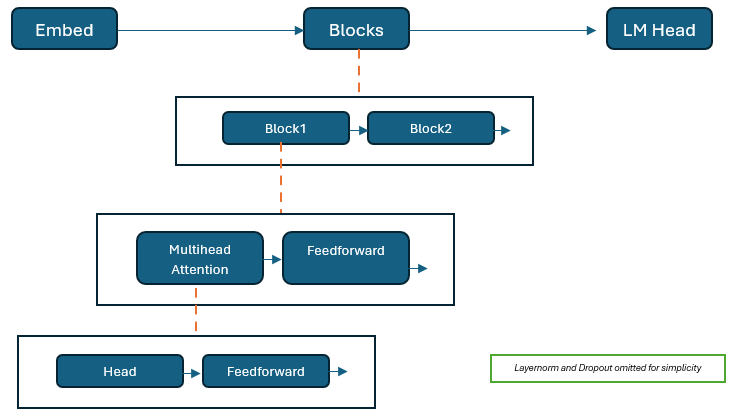

Let us now rewrite using torch class because the further coding is dififcult if written in numpy.
* the embeddings using `torch.nn.Embedding()`
* a dummy operation (placeholder) in place of Blocks which is just division by 2
* a simple 1 layer feedforward LM Head using `nn.Linear()`

As mentioned earlier, we are skipping dropout and layer normalization from this document.

In [9]:
import torch
import torch.nn as nn

x = torch.from_numpy(x)
inputs = x[:,:-1] # predictor sequences
targets = x[:,1:] # predictable sequences

###################################################################################

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Creating instance of required torch nn classes
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx):
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = x_embed / 2 # PLACEHOLDER FOR TRANSFORMER BLOCKS
        x_raw_logits = self.lm_head(x_t_out)
        
        return x_raw_logits

###################################################################################

# Call instance of our model class
model = GPTLanguageModel()

# Pass predictor sequence through the model
x_raw_logits = model(idx = inputs)

print("x_raw_logits.shape: ", x_raw_logits.shape)
print("\nSum of raw logits of first token in the first sequence: \n", torch.sum(x_raw_logits[0,0,:]))

x_raw_logits.shape:  torch.Size([4, 5, 100])

Sum of raw logits of first token in the first sequence: 
 tensor(-3.1362, grad_fn=<SumBackward0>)


The very last LM Head is designed to convert $B \times t \times C$ logits to $B \times t \times V$ logits so that it can correspnd to $V$ vocabulary items.

For a well trained model output, each $V$ dimensional logit vector should have high values for only those vocabulary items which produce contextually similar text. However, it doesn't necessarily sum to 1. To get a probability it needs to sum to 1 across the vocabulary dimension so that we know what is the probability of a token being similar to each of the 100 possible tokens.

If we apply softmax across the vocab dimension, we can get the most probable vocabulary item.

In [10]:
x_logits = torch.softmax(x_raw_logits, axis=2)
print("Sum of softmax logits of first token in the first sequence as probability:\n", torch.sum(x_logits[0,0,:]))

Sum of softmax logits of first token in the first sequence as probability:
 tensor(1.0000, grad_fn=<SumBackward0>)


Let's rewrite this by including the softmax conversion in the model class.

In [11]:
import torch
import torch.nn as nn

inputs = x[:,:-1] # predictor sequences
targets = x[:,1:] # predictable sequences

###################################################################################

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx):
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = x_embed / 2
        x_raw_logits = self.lm_head(x_t_out)
        x_logits = torch.softmax(x_raw_logits, axis=2) ##### MODIFICATION AFTER ABOVE CELL
        
        return x_logits

###################################################################################

# Call instance of our model class
model = GPTLanguageModel()

# Pass predictor sequence through the model
x_logits = model(idx = inputs)

print("x_logits.shape: ", x_logits.shape)
print("Sum of softmax logits of first token in the first sequence as probability:\n", torch.sum(x_logits[0,0,:]))

x_logits.shape:  torch.Size([4, 5, 100])
Sum of softmax logits of first token in the first sequence as probability:
 tensor(1.0000, grad_fn=<SumBackward0>)


### Targets and loss

We have been passing only the predictor sequence in this model, whereas during training, it needs to pass both predictor sequence and predictable sequence, so that the model can compute loss in predicting the predictable sequence given the predictor sequence.

Let's rewrite the model class by including this.

In [12]:
import torch
import torch.nn as nn

inputs = x[:,:-1] # predictor sequences
targets = x[:,1:] # predictable sequences

###########################################################################

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx, targets=None): ### MODIFICATION AFTER ABOVE CELL
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = x_embed / 2
        x_raw_logits = self.lm_head(x_t_out)
        x_logits = torch.softmax(x_raw_logits, axis=2)

        ###### MODIFICATION AFTER ABOVE CELL #######
        if targets is None:
            loss = None
        else:
            B, t, C = x_logits.shape
            logits = x_logits.view(B*t, C)
            targets = targets.contiguous().view(B*t) # When we pick targets in a batch, it will be contiguous by default
            loss = nn.functional.cross_entropy(logits, targets) # The error in predicting 'targets' sequence given 'inputs' sequence
        #############################################

        return x_logits, loss

###################################################################################

# Call instance of our model class
model = GPTLanguageModel()

# Pass predictor sequence through the model
x_logits, loss = model(idx = inputs, targets = targets)

print("x_logits.shape: ", x_logits.shape)
print("\nSum of softmax logits of first token in the first sequence as probability:\n", torch.sum(x_logits[0,0,:]))
print("\nloss: ", loss)

x_logits.shape:  torch.Size([4, 5, 100])

Sum of softmax logits of first token in the first sequence as probability:
 tensor(1., grad_fn=<SumBackward0>)

loss:  tensor(4.6055, grad_fn=<NllLossBackward0>)


### Inference/ Generation

After we train this model, we can expect that, given `inputs x[:,:-1]`, the model would provide reliable probabilities for what the subsequent sequence i.e. `targets x[:,1:]` should be. So, if this is inputs `["I", "need", "my"]`, we can expect that these should be most probable outputs `["need", "my", "book"]`. That is, for each 3 tokens we get a vector of 100 probabilities corresponding to 100 vocabulary items, as per the token ids as we formed the `Embedding()`. The vector for first token has highest probabilty for `"need"`, same for second is `"my"`. Ofcourse we dont need `["need", "my", "book"]` to be generated, rather only `"book"` needs to be generated.

In [13]:
output_tokens = 10 # How many new tokens need to be generated

result = x # Setting a counter for repeated model pass

for i in range(output_tokens):

    new_inputs = result[:, -(T-1):]
    x_logits, _ = model(idx = new_inputs, targets = None)
    next_token_probability = x_logits[:,-1,:] # because we only need to generate last token
    predicted_next_token = torch.argmax(next_token_probability, axis = 1)
    result = torch.cat((result, predicted_next_token.unsqueeze(1)), dim=1)

print("Here are the sequences with {} next tokens predicted\n\n".format(output_tokens), 
      result)

Here are the sequences with 10 next tokens predicted

 tensor([[37, 12, 72,  9, 75,  5,  6, 47, 45, 42, 87, 47, 45, 42, 87, 47],
        [79, 64, 16,  1, 76, 71, 45, 42, 87, 47, 45, 42, 87, 47, 45, 42],
        [ 6, 25, 50, 20, 18, 84, 47, 45, 42, 87, 47, 45, 42, 87, 47, 45],
        [11, 28, 29, 14, 50, 68, 45, 42, 87, 47, 45, 42, 87, 47, 45, 42]])


Now we can just decode these integers to respectve tokens to create the string sequence. For simplification, we considered an imagnery vocabulary of 100 tokens which is why not able to demonstrate this.

The model is not trained with attention yet, so these predicted tokens are not expected to be good. Also, there is high amount of repetition. The repitition can be handled by adding random sampling from `multinomial(next_token_probability)` rather than choosing `argmax(next_token_probability)` and further controlling the randomness with temprature smoothing.

#### Discussion: Why does it work for inferring on shorter sequence?

I always wondered how this can work for a shorter sequence. It works because in the model so far, there is no communication between positions of `inputs`. All the calculations are applied separately for each position of `inputs`. The positional embedding has max `(T - 1)` lookup rows, so a shorter sequence fits.

In [14]:
output_tokens = 10 # How many new tokens need to be generated

result = torch.randint(0,99,(4,3))
print("Input Sequence (Prompt): \n", result)

for i in range(output_tokens):

    new_inputs = result[:, -(T-1):]
    x_logits, _ = model(idx = new_inputs, targets = None)
    next_token_probability = x_logits[:,-1,:] # because we only need to generate last token
    predicted_next_token = torch.argmax(next_token_probability, axis = 1)
    result = torch.cat((result, predicted_next_token.unsqueeze(1)), dim=1)

print("\n\nHere are the sequences with {} next tokens predicted\n".format(output_tokens), 
      result)

Input Sequence (Prompt): 
 tensor([[13, 56,  5],
        [89, 74, 45],
        [24, 37, 46],
        [94, 21, 75]])


Here are the sequences with 10 next tokens predicted
 tensor([[13, 56,  5, 27, 58,  6, 47, 45, 42, 87, 47, 45, 42],
        [89, 74, 45, 42, 42, 87, 47, 45, 42, 87, 47, 45, 42],
        [24, 37, 46, 42, 42, 87, 47, 45, 42, 87, 47, 45, 42],
        [94, 21, 75, 27, 58,  6, 47, 45, 42, 87, 47, 45, 42]])


However, attention is supposed to happen across tokens. Let's go through attention is **Part 2** and check why would a shorter sequence work for attention as well.